## find_remaining_variables.ipynb

In this notebook, we find various variables for politicians and non-politicians. We first extract all election- and election-history related data. For the non-politicians, the names come directly from the elections data. Hence, we do not have to string match. For the politicians, we have to match the names of the politicians to the names in the elections dataset. 

Secondly, we extract demographic and district data 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from rdrobust import rdrobust,rdbwselect,rdplot

/home/bas/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [2]:
# Read the data
data = pd.read_csv("../Data/analysis/unmatched_sample_analysis.csv", dtype={'b1-nummer':str}).iloc[:,1:]
# (or some other dataset)
data.head(20)

,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated
0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN
1,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN
2,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN
3,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN
4,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN
5,01316,C.M. Storm van 's Gravesande,Enschede,30/11/1848,538774.18,0.096639,08-07-1880,395608.196401
6,00872,M.J. de Man,Enschede,16/12/1848,NaN,0.148225,22-12-1854,NaN
7,01361,J.R. Thorbecke,Zutphen,30/11/1848,NaN,0.137143,04-06-1872,NaN
8,01504,S. van Walchren,Amersfoort,30/11/1848,NaN,0.007092,16-01-1871,NaN
9,01504,S. van Walchren,Amersfoort,07/12/1848,NaN,0.189504,16-01-1871,NaN


## Explore the balance of observations

We take the data frame as a whole, but also as an observation for each observation in the control group

In [3]:
# All non-NA obs.
print("All observations", data[-data['Vermogen_deflated'].isnull()].shape)


# Control group
print("Control group:", 
      data[(-data['Vermogen_deflated'].isnull()) & (data['b1-nummer'].isnull())].shape
     )


# Treatment group
print("Treatment group:", 
      data[(-data['Vermogen_deflated'].isnull()) & (-data['b1-nummer'].isnull())].shape
     )

All observations (604, 8)
Control group: (256, 8)
Treatment group: (348, 8)


## Variable pick up function

We write a function that picks up all required variables, first for all observations, then for politicians and then for non-politicians. 

In [4]:
# Election and election history data
## Some datasets which I need
electoral_data = pd.read_csv("../Data/elections/election_results_details.csv").iloc[:,1:]
electoral_data.iloc[:,[2,7,8,9,10,11,12,13]] = electoral_data.iloc[:,[2,7,8,9,10,11,12,13]].apply(lambda x: pd.to_numeric(x, errors='coerce'))
electoral_data['Verkiezingdatum'] = electoral_data['Verkiezingdatum'].apply(lambda x: pd.Timestamp(x))

## Seats data
zetels = electoral_data.groupby(['District', 'Verkiezingdatum']).agg({'Aantal zetels': 'mean'})

## Politician metadata
politician_metadata = pd.read_excel("../Data/politician_data/tk_1815tot1950uu.xlsx", dtype={'b1-nummer':str})
politician_metadata2 = pd.read_excel("../Data/politician_data/tk_1815tot1950uu.xlsx", sheet_name = 1, dtype={'b1-nummer':str})


In [5]:
electoral_data.head(5)

,Naam,Aanbevolen door,Aantal stemmen,Procentueel,District,Verkiezingdatum,Type,Omvang electoraat,Opkomst,Aantal stembriefjes,Aantal stemmen geldig,Aantal stemmen blanco,Aantal zetels,Kiesdrempel
0,mr. B. Wichers,NaN,700.0,83.73%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
1,W.L. de Sturler,NaN,34.0,4.07%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
2,mr. A. Oudeman,NaN,22.0,2.63%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
3,L.T. Jorissen,NaN,21.0,2.51%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
4,jhr.mr. O.Q.J.J. van Swinderen,NaN,14.0,1.67%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0


In [6]:
politician_metadata2.head(5)

,b1-nummer,rubriek,waarde,datum,toelichting
0,00001,3010,Leiden,27-03-1871,NaN
1,00001,3020,'s-Gravenhage,05-07-1948,NaN
2,00001,3500,advocaat en procureur te Leiden,26-11-1897/01-06-1916,sinds 1905 liet hij de praktijk over aan zijn ...
3,00001,3500,lid gemeenteraad van Leiden,26-09-1899/18-06-1903,NaN
4,00001,3500,"wethouder (van burgerlijke stand, sociale aang...",26-09-1901/18-06-1903,NaN


In [7]:
def get_variables(data):
    
    out = pd.DataFrame()
    
    for i in tqdm(range(len(data))):
        
        # For everyone:
        ## How many times did you participate in elections before this time?
        electoral_data_before = electoral_data[electoral_data['Verkiezingdatum'] < pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        before = electoral_data_before[electoral_data_before['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
    
        ## How many times afterwards?
        electoral_data_after = electoral_data[electoral_data['Verkiezingdatum'] > pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        after = electoral_data_after[electoral_data_after['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
    
        ## How long did you live after this election? (in days)
        try:
            lifespan = (pd.Timestamp(data.iloc[i]['Sterfdatum']) - pd.Timestamp(data.iloc[i]['Verkiezingdatum']))/ pd.Timedelta(1, unit='d')
        
        except:
            lifespan = None
        
        ### Variables specific to the election
        
        ## What kind of election?
        election_type = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Type']
        
        ## Did you have a party?
        party_election = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aanbevolen door']
    
        ## How many absolute votes?
        amount_votes = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aantal stemmen']
    
        ## How many seats in this district?
        amount_seats = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aantal zetels']
        turnout = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Opkomst']
        kiesdrempel = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Kiesdrempel']
    
        # For the politicians only
        if data.iloc[i]['b1-nummer'] is None:
            
            begin_period = None
            end_period = None
            tenure = None
            date_of_birth = None
            
        else: 
            begin_period = politician_metadata[politician_metadata['b1-nummer'] == data.iloc[i]['b1-nummer']]['begin periode']
            end_period = politician_metadata[politician_metadata['b1-nummer'] == data.iloc[i]['b1-nummer']]['einde periode']
            try:
                tenure = pd.Timestamp(end_period.values[0]) - pd.Timestamp(begin_period.values[0])
            except:
                tenure = None
                
            date_of_birth = politician_metadata2[(politician_metadata2['b1-nummer'] == data.iloc[i]['b1-nummer']) & (politician_metadata2['rubriek'] == 3010)]['datum']
     
        ## Now, we add all data points to the dataframe
        
        #print(type(before), "\n", type(after), "\n", type(lifespan), "\n", type(party_election), "\n",
        #     type(amount_votes), "\n", type(amount_seats), "\n", type(turnout), "\n", type(kiesdrempel), "\n")
        interim = pd.DataFrame([data.iloc[i]])
        
        # Make all variables        
        interim['before'] = before
        interim['after'] = after
        interim['lifespan'] = lifespan
        interim['election_type']  = election_type.values[0] if len(election_type.values) else None
        interim['party_election'] = party_election.values[0] if len(party_election.values) else None
        interim['amount_votes'] =  amount_votes.values[0] if len(amount_votes.values) else None
        interim['amount_seats'] = amount_seats.values[0] if len(amount_seats.values) else None
        interim['turnout'] = turnout.values[0] if len(turnout.values) else None
        interim['kiesdrempel'] = kiesdrempel.values[0] if len(kiesdrempel.values) else None
        interim['begin_period'] = begin_period.values[0] if len(begin_period.values) else None
        interim['end_period'] = end_period.values[0] if len(end_period.values) else None
        interim['tenure'] = tenure
        interim['date_of_birth'] = date_of_birth.values[0] if len(date_of_birth.values) else None
        
        interim = interim.reset_index()
        
        ## Finally, add the interim dataframe to the output dataframe that returns the input plus the appended variables    
        out = out.append(interim)
        
    return(out)

In [8]:
data_with_vars = get_variables(data)

data_with_vars.head(5)

100%|██████████| 1271/1271 [01:01<00:00, 20.54it/s]


,index,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated,before,...,election_type,party_election,amount_votes,amount_seats,turnout,kiesdrempel,begin_period,end_period,tenure,date_of_birth
0,0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN,0,...,algemeen,NaN,257.0,1.0,722.0,361.0,1849-02-13,1869-02-23,7315 days 00:00:00,15-08-1790
0,1,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN,1,...,tussentijds,NaN,225.0,1.0,686.0,342.0,1849-02-13,1874-03-24,9170 days 00:00:00,14-03-1801
0,2,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN,1,...,algemeen,NaN,245.0,1.0,835.0,414.0,1844-10-22,1850-08-19,2127 days 00:00:00,22-04-1801
0,3,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN,0,...,None,None,None,None,None,None,1849-02-13,1869-02-23,7315 days 00:00:00,15-08-1790
0,4,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN,3,...,herstemming,NaN,267.0,1.0,480.0,240.0,1849-02-13,1850-08-19,552 days 00:00:00,19-10-1792


/home/bas/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log


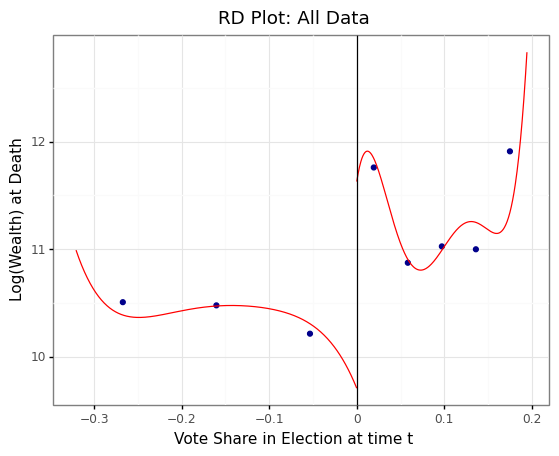


Call: rdplot
Number of Observations:                   574
Kernel:                               Uniform
Polynomial Order Est. (p):                  5

                                Left      Right
------------------------------------------------
Number of Observations           251        323
Number of Effective Obs          251        323
Bandwith poly. fit (h)         0.321      0.194
Number of bins scale               1          1
Bins Selected                      3          5
Average Bin Length             0.107      0.039
Median Bin Length              0.107      0.039
IMSE-optimal bins                3.0        5.0
Mimicking Variance bins         19.0       17.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [9]:
rdplot(y=np.log(1+data_with_vars['Vermogen_deflated']), x=data_with_vars['margin'], binselect="es", p=5,
         title="RD Plot: All Data", 
         y_label="Log(Wealth) at Death",
         x_label="Vote Share in Election at time t")


In [10]:
data_with_vars.to_csv("../Data/analysis/unmatched_sample_with_vars.csv")

In [11]:
data_with_vars['Sterfdatum'] = data_with_vars['Sterfdatum'].apply(lambda x: pd.to_datetime(x, errors='coerce'))
data_with_vars2 = data_with_vars[(data_with_vars['Sterfdatum'] < pd.Timestamp('1928-01-01')) | (pd.isnull(data_with_vars['Sterfdatum']))]

/home/bas/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log


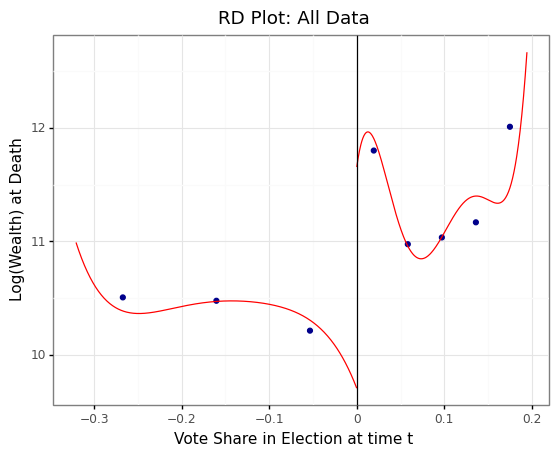


Call: rdplot
Number of Observations:                   548
Kernel:                               Uniform
Polynomial Order Est. (p):                  5

                                Left      Right
------------------------------------------------
Number of Observations           251        297
Number of Effective Obs          251        297
Bandwith poly. fit (h)         0.321      0.194
Number of bins scale               1          1
Bins Selected                      3          5
Average Bin Length             0.107      0.039
Median Bin Length              0.107      0.039
IMSE-optimal bins                3.0        5.0
Mimicking Variance bins         18.0       16.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [12]:
rdplot(y=np.log(1+data_with_vars2['Vermogen_deflated']), x=data_with_vars2['margin'], binselect="es", p=5,
         title="RD Plot: All Data", 
         y_label="Log(Wealth) at Death",
         x_label="Vote Share in Election at time t")
